In [1]:
import os, sys
import subprocess
import json
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
from coffea import processor, util, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from boostedhiggs import VBFArrayProcessor

In [3]:
with open('xsec.json') as f:
    xs = json.load(f)
with open('pmap.json') as f:
    pmap = json.load(f)
with open('lumi.json') as f:
    lumis = json.load(f)
years = ['2017','2018']

In [4]:
df_dict = {}

for year in years:
    
    df_dict[year] = {}
    infiles = subprocess.getoutput("ls outfiles-array/"+year+"_dask_*.coffea").split()

    for filename in infiles:
        print("Loading "+filename)

        if os.path.isfile(filename):
            out = util.load(filename)
        
            for k in out.keys():
                cols = list(out[k].keys())
                cols.remove('sumw')
                if 'btagWeight' in cols:
                    cols.remove('btagWeight')
                cols.remove('subjet1_pt')
                cols.remove('subjet1_eta')
                cols.remove('subjet1_phi')
                cols.remove('subjet2_pt')
                cols.remove('subjet2_eta')
                cols.remove('subjet2_phi')
                
                df = pd.DataFrame(columns=cols)
                for c in cols:
                    df[c] = out[k][c].value
                
                if 'JetHT' not in k and 'SingleMuon' not in k:
                    df['weight'] = df['weight'] * xs[k] * 1000 * lumis[year] / out[k]['sumw']

                df_dict[year][k] = df 


Loading outfiles-array/2017_dask_GluGluHToBB.coffea
Loading outfiles-array/2017_dask_JetHTData.coffea
Loading outfiles-array/2017_dask_QCD.coffea
Loading outfiles-array/2017_dask_VBFHToBB.coffea
Loading outfiles-array/2018_dask_GluGluHToBB.coffea
Loading outfiles-array/2018_dask_JetHTData.coffea
Loading outfiles-array/2018_dask_QCD.coffea
Loading outfiles-array/2018_dask_VBFHToBB.coffea


In [5]:
dfs = {}

for year in years:
    dfs[year] = {}  
        
dfs['allyears'] = {}

for k in pmap.keys():
    
    dfs['allyears'][k] = pd.DataFrame()

    for year in years:

        processes = [df_dict[year][p] for p in pmap[k] if p in df_dict[year].keys()]
        if len(processes) == 0:
            continue
        
        # only consider H mass window
        dfs[year][k] = pd.concat(processes)
        dfs[year][k] = dfs[year][k][(dfs[year][k]['msd']>115) & (dfs[year][k]['msd']<135)]
        
        
        dfs['allyears'][k] = pd.concat([dfs['allyears'][k],dfs[year][k]])

In [6]:
dfs['allyears']['data'].columns

Index(['genflavor', 'pt', 'eta', 'phi', 'n2ddt', 'msd', 'ddb', 'deta', 'dphi',
       'mjj', 'njets', 'ht', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_qgl',
       'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_qgl', 'jet3_pt', 'jet3_eta',
       'jet3_phi', 'jet3_qgl', 'met', 'weight'],
      dtype='object')

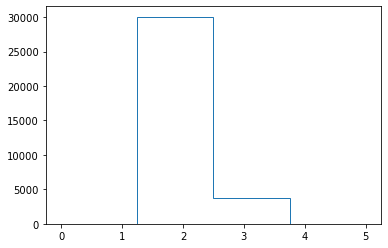

Text(0.5, 0.98, '115 GeV $ < m_{sd} < $ 135 GeV')

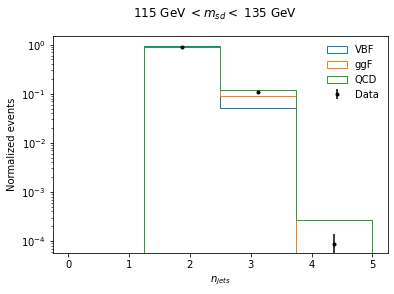

In [7]:
year='allyears'

var = "njets"
bins = np.linspace(0,5,5)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'$n_{jets}$')
plt.suptitle('115 GeV $ < m_{sd} < $ 135 GeV')

In [8]:
print(100*len(dfs[year]['VBF'][dfs[year]['VBF']['njets']>2])/len(dfs[year]['VBF']))

5.064993276557598


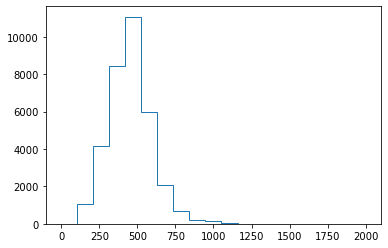

Text(0.5, 0.98, '115 GeV $ < m_{sd} < $ 135 GeV')

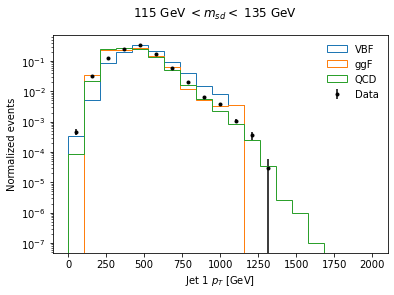

In [9]:
year='allyears'

var = "jet1_pt"
bins = np.linspace(0,2000,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'Jet 1 $p_T$ [GeV]')
plt.suptitle('115 GeV $ < m_{sd} < $ 135 GeV')

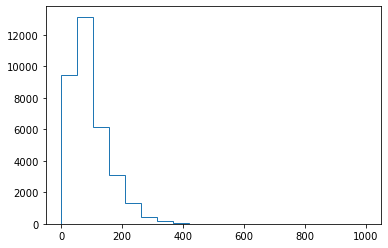

Text(0.5, 0.98, '115 GeV $ < m_{sd} < $ 135 GeV')

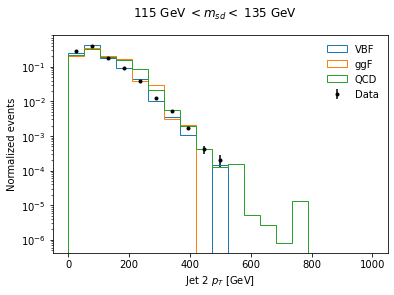

In [10]:
year='allyears'

var = "jet2_pt"
bins = np.linspace(0,1000,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'Jet 2 $p_T$ [GeV]')
plt.suptitle('115 GeV $ < m_{sd} < $ 135 GeV')

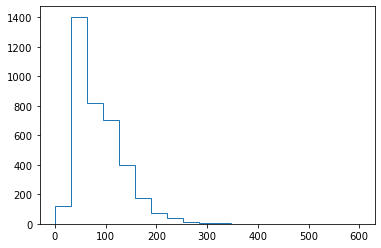

Text(0.5, 0.98, '115 GeV $ < m_{sd} < $ 135 GeV')

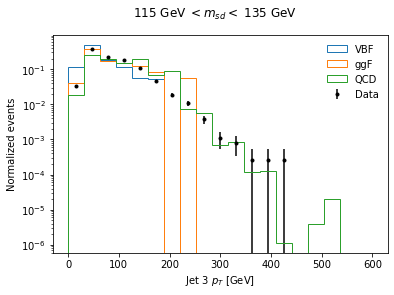

In [11]:
year='allyears'

var = "jet3_pt"
bins = np.linspace(0,600,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2

dfs2 = {}

for p in ['VBF','ggF','QCD','data']:
    dfs2[p] = dfs[year][p][dfs[year][p][var]>0]
    
h = plt.hist(dfs2['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs2['VBF'][var],histtype='step',weights=dfs2['VBF']['weight']/np.sum(dfs2['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs2['ggF'][var],histtype='step',weights=dfs2['ggF']['weight']/np.sum(dfs2['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs2['QCD'][var],histtype='step',weights=dfs2['QCD']['weight']/np.sum(dfs2['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'Jet 3 $p_T$ [GeV]')
plt.suptitle('115 GeV $ < m_{sd} < $ 135 GeV')

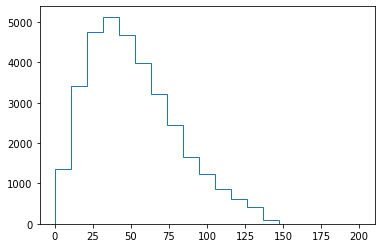

Text(0.5, 0.98, '115 GeV $ < m_{sd} < $ 135 GeV')

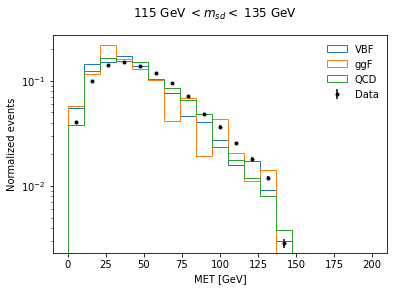

In [12]:
year='allyears'

var = "met"
bins = np.linspace(0,200,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
  
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'MET [GeV]')
plt.suptitle('115 GeV $ < m_{sd} < $ 135 GeV')

In [13]:
dfs = {}

for year in years:
    dfs[year] = {}  
        
dfs['allyears'] = {}

for k in pmap.keys():
    
    dfs['allyears'][k] = pd.DataFrame()

    for year in years:

        processes = [df_dict[year][p] for p in pmap[k] if p in df_dict[year].keys()]
        if len(processes) == 0:
            continue
        
        # only consider H mass window
        dfs[year][k] = pd.concat(processes)
        dfs[year][k] = dfs[year][k][(dfs[year][k]['msd']<115)]
        
        
        dfs['allyears'][k] = pd.concat([dfs['allyears'][k],dfs[year][k]])

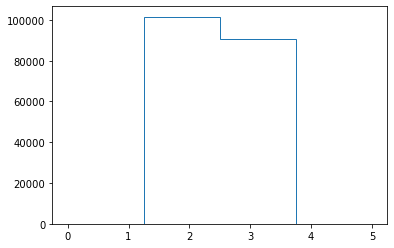

Text(0.5, 0.98, '$m_{sd} < $ 115 GeV')

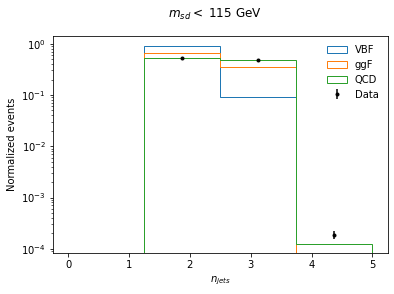

In [14]:
year='allyears'

var = "njets"
bins = np.linspace(0,5,5)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'$n_{jets}$')
plt.suptitle('$m_{sd} < $ 115 GeV')

In [15]:
print(100*len(dfs[year]['data'][dfs[year]['data']['njets']>2])/len(dfs[year]['data']))

47.22098063469954


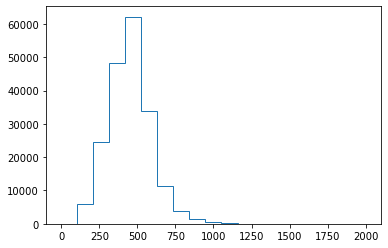

Text(0.5, 0.98, '$m_{sd} < $ 115 GeV')

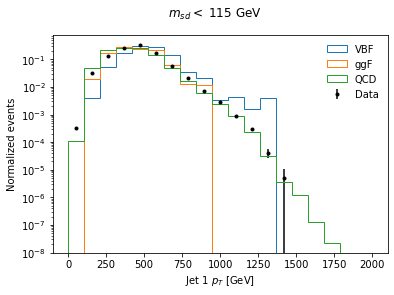

In [16]:
year='allyears'

var = "jet1_pt"
bins = np.linspace(0,2000,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'Jet 1 $p_T$ [GeV]')
plt.suptitle('$m_{sd} < $ 115 GeV')

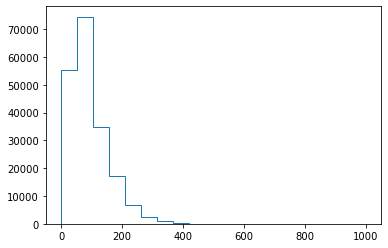

Text(0.5, 0.98, '$m_{sd} < $ 115 GeV')

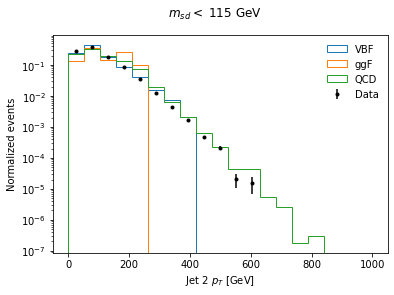

In [17]:
year='allyears'

var = "jet2_pt"
bins = np.linspace(0,1000,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'Jet 2 $p_T$ [GeV]')
plt.suptitle('$m_{sd} < $ 115 GeV')

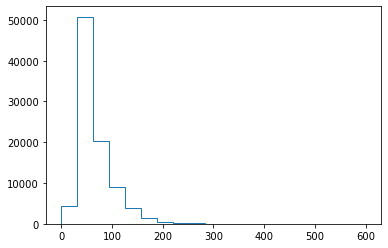

Text(0.5, 0.98, '$m_{sd} < $ 115 GeV')

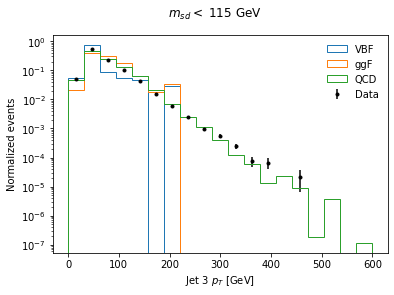

In [18]:
year='allyears'

var = "jet3_pt"
bins = np.linspace(0,600,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2

dfs2 = {}

for p in ['VBF','ggF','QCD','data']:
    dfs2[p] = dfs[year][p][dfs[year][p][var]>0]
    
h = plt.hist(dfs2['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs2['VBF'][var],histtype='step',weights=dfs2['VBF']['weight']/np.sum(dfs2['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs2['ggF'][var],histtype='step',weights=dfs2['ggF']['weight']/np.sum(dfs2['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs2['QCD'][var],histtype='step',weights=dfs2['QCD']['weight']/np.sum(dfs2['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'Jet 3 $p_T$ [GeV]')
plt.suptitle('$m_{sd} < $ 115 GeV')

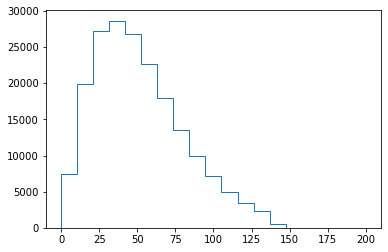

Text(0.5, 0.98, '$m_{sd} < $ 115 GeV')

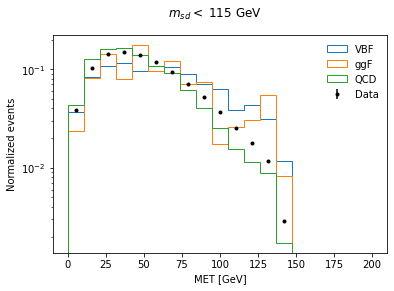

In [19]:
year='allyears'

var = "met"
bins = np.linspace(0,200,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
  
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'MET [GeV]')
plt.suptitle('$m_{sd} < $ 115 GeV')

In [20]:
dfs = {}

for year in years:
    dfs[year] = {}  
        
dfs['allyears'] = {}

for k in pmap.keys():
    
    dfs['allyears'][k] = pd.DataFrame()

    for year in years:

        processes = [df_dict[year][p] for p in pmap[k] if p in df_dict[year].keys()]
        if len(processes) == 0:
            continue
        
        # only consider H mass window
        dfs[year][k] = pd.concat(processes)
        dfs[year][k] = dfs[year][k][(dfs[year][k]['msd']>160)]
        
        
        dfs['allyears'][k] = pd.concat([dfs['allyears'][k],dfs[year][k]])

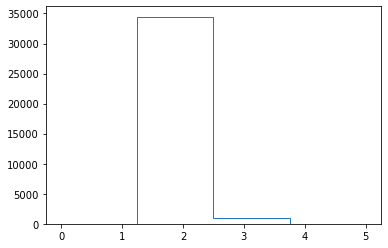

Text(0.5, 0.98, '$m_{sd} > $ 160 GeV')

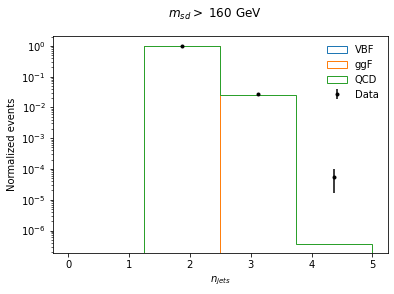

In [21]:
year='allyears'

var = "njets"
bins = np.linspace(0,5,5)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'$n_{jets}$')
plt.suptitle('$m_{sd} > $ 160 GeV')

In [22]:
print(100*len(dfs[year]['data'][dfs[year]['data']['njets']>2])/len(dfs[year]['data']))

2.6911781317067662


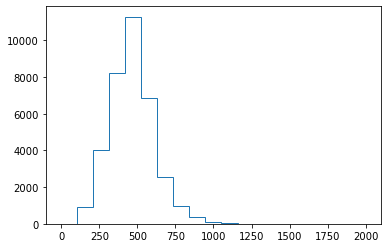

Text(0.5, 0.98, '$m_{sd} > $ 160 GeV')

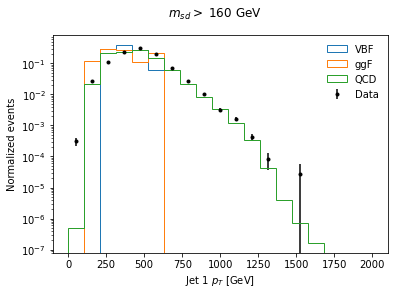

In [23]:
year='allyears'

var = "jet1_pt"
bins = np.linspace(0,2000,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'Jet 1 $p_T$ [GeV]')
plt.suptitle('$m_{sd} > $ 160 GeV')

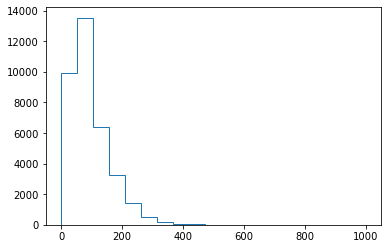

Text(0.5, 0.98, '$m_{sd} > $ 160 GeV')

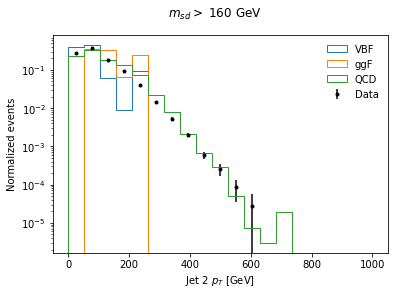

In [24]:
year='allyears'

var = "jet2_pt"
bins = np.linspace(0,1000,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'Jet 2 $p_T$ [GeV]')
plt.suptitle('$m_{sd} > $ 160 GeV')

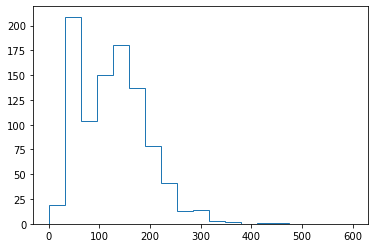

Text(0.5, 0.98, '$m_{sd} > $ 160 GeV')

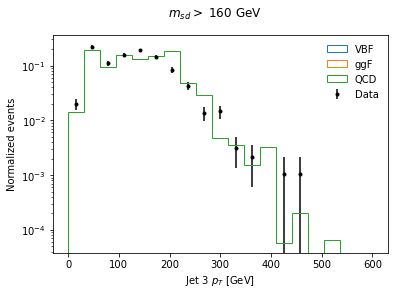

In [25]:
year='allyears'

var = "jet3_pt"
bins = np.linspace(0,600,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2

dfs2 = {}

for p in ['VBF','ggF','QCD','data']:
    dfs2[p] = dfs[year][p][dfs[year][p][var]>0]
    
h = plt.hist(dfs2['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
plt.hist(dfs2['VBF'][var],histtype='step',weights=dfs2['VBF']['weight']/np.sum(dfs2['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs2['ggF'][var],histtype='step',weights=dfs2['ggF']['weight']/np.sum(dfs2['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs2['QCD'][var],histtype='step',weights=dfs2['QCD']['weight']/np.sum(dfs2['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'Jet 3 $p_T$ [GeV]')
plt.suptitle('$m_{sd} > $ 160 GeV')

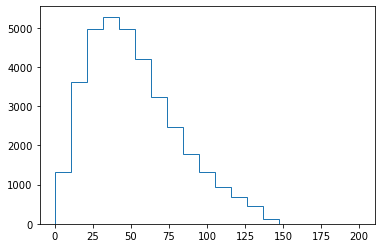

Text(0.5, 0.98, '$m_{sd} > $ 160 GeV')

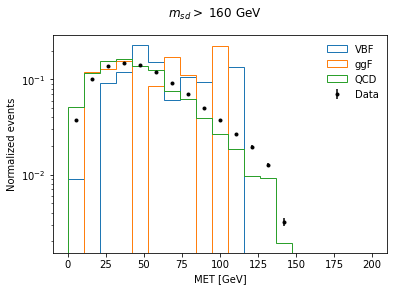

In [26]:
year='allyears'

var = "met"
bins = np.linspace(0,200,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data'][var],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
  
plt.hist(dfs[year]['VBF'][var],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
plt.hist(dfs[year]['ggF'][var],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
plt.hist(dfs[year]['QCD'][var],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper right')
plt.ylabel('Normalized events')
plt.yscale('log')
plt.xlabel(r'MET [GeV]')
plt.suptitle('$m_{sd} > $ 160 GeV')

In [27]:
dfs = {}

for year in years:
    dfs[year] = {}  
        
dfs['allyears'] = {}

for k in pmap.keys():
    
    dfs['allyears'][k] = pd.DataFrame()

    for year in years:

        processes = [df_dict[year][p] for p in pmap[k] if p in df_dict[year].keys()]
        if len(processes) == 0:
            continue
        
        # only consider H mass window
        dfs[year][k] = pd.concat(processes)
        
        dfs['allyears'][k] = pd.concat([dfs['allyears'][k],dfs[year][k]])

In [28]:
print(100*len(dfs[year]['data'][dfs[year]['data']['njets']>2])/len(dfs[year]['data']))

33.381862046733154


In [29]:
print(100*len(dfs[year]['VBF'][dfs[year]['VBF']['njets']>2])/len(dfs[year]['VBF']))

5.4035087719298245
